Author: Mike Stanley <br>
Written: 9/2/2018

This notebook is to see how well the hierarchical dirichlet process model does at infering 2 data generating distributions from one dimensional data.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import pymc3 as pm
from theano import tensor as T
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


$f(x) = \frac{n!}{x_1! \cdots x_k!} p_1^{x_1} \cdots p_k^{x_k}$

# Generate Data

In [20]:
N = 1000

# decide what distribution sampling from
z = np.random.choice(np.arange(3), size=N, p = [0.1, 0.6, 0.3])

# define the different bin distributions
dist0 = stats.norm(loc=-3, scale=1)
dist1 = stats.norm(loc=1, scale=3)
dist2 = stats.norm(loc=5, scale=1)

dist_dict = {0:dist0, 1:dist1, 2:dist2}

# create bin for data
data = np.zeros(shape=N)

for idx, z_i in enumerate(z):
    data[idx] = dist_dict[z_i].rvs()

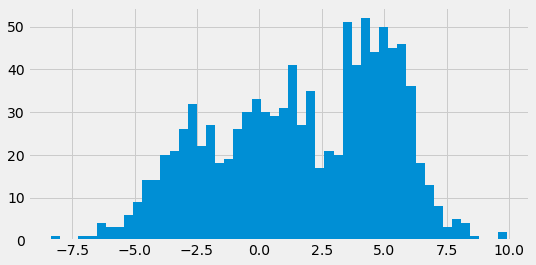

In [22]:
# plot the above
plt.figure(figsize=(8, 4))
plt.hist(data, bins=50)
plt.show()

# Normal Data with pymc3

In [79]:
with pm.Model() as normal_sampler:
    x = pm.Normal('x', 0., 2.)

In [80]:
# sample from the above
with normal_sampler:
    x_sample = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2763.15draws/s]


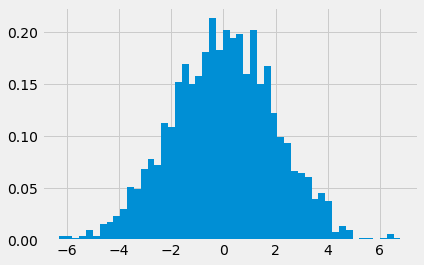

In [84]:
plt.hist(x_sample['x'], bins=50, density=True)
plt.show()

In [86]:
# get stats on the above dist
x_sample['x'].std(), x_sample['x'].var()

(1.9747520701671732, 3.8996457386295362)

In [87]:
# what about the stats.norm dist
stats.norm.rvs(loc=0, scale=2, size=1000).std()

2.0125402848180136

# Learn the mixing components

In [23]:
# number of mixing components
K = 30

In [134]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1, alpha, shape=K)
    w = pm.Deterministic('w', beta * T.concatenate([[1], T.extra_ops.cumprod(1 - beta[:-1])]))
    component = pm.Categorical('component', w, shape=N)
    
    #tau = pm.Gamma('tau', 1., 1., shape=K)
    #lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    gamma = pm.InverseGamma('inv_gamma', 1., 1., shape=K)
    #mu = pm.Normal('mu', 0, lambda_ * tau, shape=K)
    mu = pm.Normal('mu', 0., 20., shape=K)
    #obs = pm.Normal('obs', mu[component], lambda_[component] * tau[component], 
    obs = pm.Normal('obs', mu[component], gamma[component],
                    observed=data)

In [135]:
with model:
    #step1 = pm.Metropolis(vars=[alpha, beta, w, lambda_, tau, mu, obs])
    step1 = pm.Metropolis(vars=[alpha, beta, w, gamma, mu, obs])
    step2 = pm.ElemwiseCategorical([component], np.arange(K))
    
    trace_ = pm.sample(20000, [step1, step2])
    
trace = trace_[10000::10]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  after removing the cwd from sys.path.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [mu]
>>Metropolis: [inv_gamma]
>>Metropolis: [beta]
>>Metropolis: [alpha]
>ElemwiseCategorical: [component]
Sampling 2 chains: 100%|██████████| 41000/41000 [06:53<00:00, 99.19draws/s] 
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


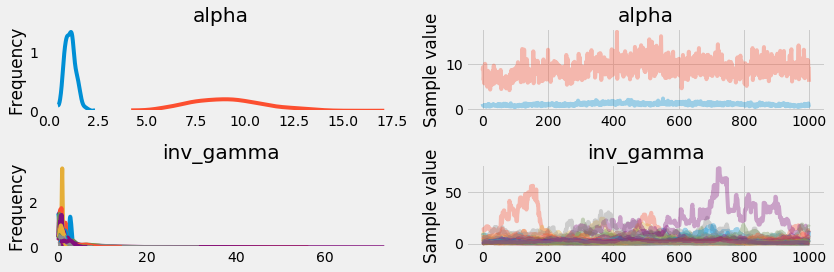

In [137]:
pm.traceplot(trace, varnames=['alpha', 'inv_gamma'])
plt.show()

### Look at results

In [138]:
# values to plot on xaxis
x_plot = np.linspace(data.min(), data.max(), num=200)

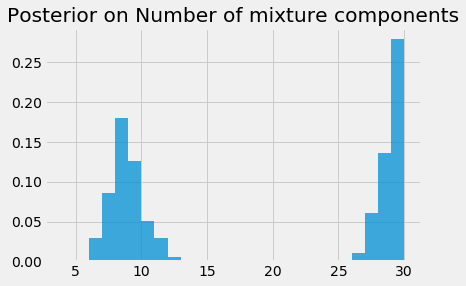

In [139]:
# number of components used
n_components = np.apply_along_axis(lambda x: np.unique(x).size, 1, trace['component'])

bins = np.arange(n_components.min(), n_components.max() + 1)
plt.hist(n_components+1, bins=bins, density=True, alpha=0.75)
plt.title('Posterior on Number of mixture components')
plt.show()

In [140]:
trace['mu'].shape

(2000, 30)

In [142]:
# compute our posterior estimates
post_pdf_contribs = stats.norm.pdf(np.atleast_3d(x_plot),
                                   trace['mu'][:,np.newaxis,:],
                                   trace['inv_gamma'][:, np.newaxis, :])
#                                   (trace['lambda'] * trace['tau'])[:, np.newaxis,:])

post_pdf = (trace['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1) # mean of all components
post_pdf_low, post_pdf_high = np.percentile(post_pdf, [2.5, 97.5], axis=0)

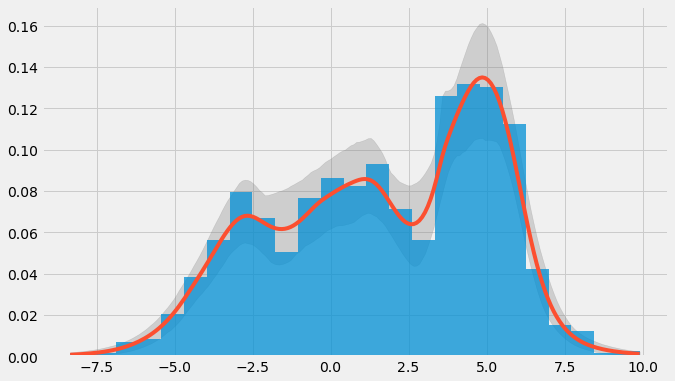

In [143]:
# plot the above with the data
plt.figure(figsize=(10, 6))

plt.hist(data, bins=25, density=True, alpha=0.75)

plt.plot(x_plot, post_pdf.mean(axis=0))
plt.fill_between(x_plot, post_pdf_low, post_pdf_high, color='gray', alpha=0.3)

plt.show()

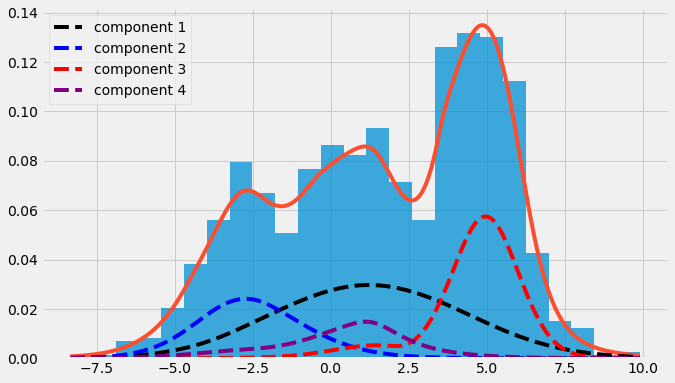

In [144]:
# now plot with components
plt.figure(figsize=(10, 6))

plt.hist(data, bins=25, density=True, alpha=0.75)

plt.plot(x_plot, post_pdf.mean(axis=0))

# components
component_pdfs = (trace['w'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0)

plt.plot(x_plot, component_pdfs[:, 0], label='component 1', 
         linestyle='--', color='k')
plt.plot(x_plot, component_pdfs[:, 1], label='component 2', 
         linestyle='--', color='blue')
plt.plot(x_plot, component_pdfs[:, 2], label='component 3', 
         linestyle='--', color='red')
plt.plot(x_plot, component_pdfs[:, 3], label='component 4', 
         linestyle='--', color='purple')

plt.legend(loc='best')
plt.show()

# Multi-dimensional case

In [53]:
# generate some higher dimensional data
P = 2
    
dist0=stats.multivariate_normal(mean=[3, 3], cov=[[1., 0.],
                                                  [0., 1.]])
dist1=stats.multivariate_normal(mean=[0, 0], cov=[[1., 0.],
                                                  [0., 1.]])

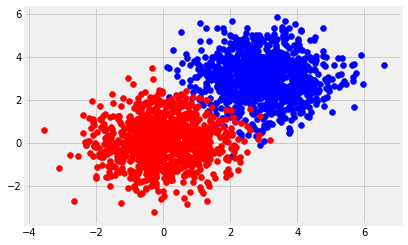

In [54]:
data1 = dist0.rvs(size=1000)
data2 = dist1.rvs(size=1000)
plt.scatter(data1[:,0], data1[:,1], color='blue', label='cluster 0')
plt.scatter(data2[:,0], data2[:,1], color='red', label='cluster 1')
plt.show()

In [57]:
# data generating process
N = 1000

# pick the distributions
cluster_choice = stats.bernoulli.rvs(p=0.3, size=N)

data_mix = np.zeros(shape=(N, 2))

for idx, i in enumerate(cluster_choice):
    if i == 0:
        data_mix[idx, :] = dist0.rvs(size=1)
    elif i == 1:
        data_mix[idx, :] = dist1.rvs(size=1)

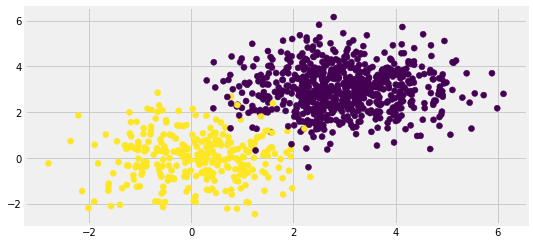

In [58]:
# plot the above
plt.figure(figsize=(8, 4))

plt.scatter(data_mix[:,0], data_mix[:, 1], c=cluster_choice)
plt.show()

### Specify the model

In [41]:
# specify the max number of clusters
K = 30

In [60]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', beta * T.concatenate([[1], T.extra_ops.cumprod(1 - beta)[:-1]]))
    component = pm.Categorical('categorical', w, shape=N)
    
    # use the LKJ Cholesky covariance priors on for cov matrix
    packed_L = pm.LKJCholeskyCov('packed_L', n=2, eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
    L = pm.expand_packed_triangular(2, packed_L)
    sig = pm.Deterministic('sig', L.dot(L.T), shape=(2, 2))
    
    mu = pm.Normal('mu', 0., 20., shape=(2,K))
    
    obs = pm.MvNormal('obs', mu, chol=L, observed=data_mix)

In [61]:
with model:
    step1 = pm.Metropolis(vars=[alpha, beta, w, packed_L, sig])
    step2 = pm.ElemwiseCategorical([component], np.arange(K))
    
    trace_ = pm.sample(20000, [step1, step2])
    
trace = trace_[10000::10]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [packed_L]
>>Metropolis: [beta]
>>Metropolis: [alpha]
>ElemwiseCategorical: [categorical]
>NUTS: [mu]
Sampling 2 chains: 100%|██████████| 41000/41000 [12:03<00:00, 56.64draws/s]
The acceptance probability does not match the target. It is 0.8890813766093368, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


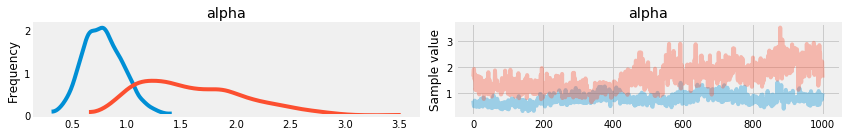

In [62]:
# look at the trace chains for alpha
pm.traceplot(trace, varnames=['alpha'])
plt.show()

In [64]:
# find the posterior for the number of components used
n_components_used = np.apply_along_axis(lambda x: np.unique(x).size, 1, trace['categorical'])

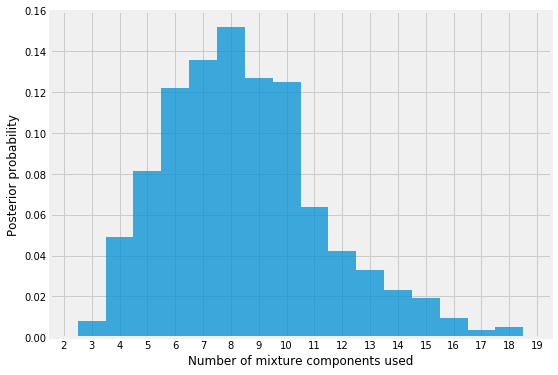

In [65]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(n_components_used.min(), n_components_used.max() + 1)
ax.hist(n_components_used + 1, bins=bins, density=True, lw=0, alpha=0.75);

ax.set_xticks(bins + 0.5);
ax.set_xticklabels(bins);
ax.set_xlim(bins.min(), bins.max() + 1);
ax.set_xlabel('Number of mixture components used');

ax.set_ylabel('Posterior probability');
plt.show()

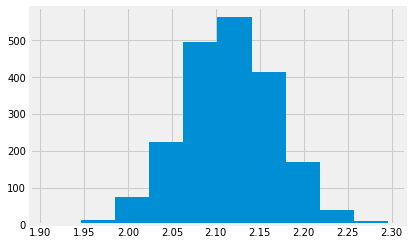

In [69]:
# look at some traces
plt.hist(trace['mu'][:,0])
plt.show()

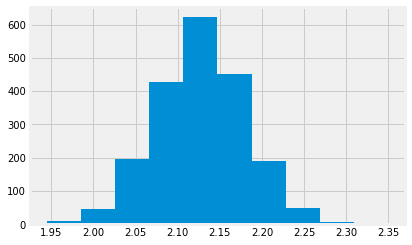

In [70]:
plt.hist(trace['mu'][:,1])
plt.show()

In [72]:
trace['sig'].shape

(2000, 2, 2)